<a href="https://colab.research.google.com/github/abishek2019/DeepLearning/blob/main/Image_classifier_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.datasets as d
import torchvision.transforms as t
import torch.utils.data as data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 1. LOAD AND NORMALIZE THE DATA
# Each image is 3*32*32.
transform = t.Compose([t.ToTensor(), t.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = d.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = data.DataLoader(dataset=train_data, batch_size=4, shuffle=True, num_workers=2)
test_date = d.CIFAR10(root='./data', train=False, transform=transform, download= True)
testloader = data.DataLoader(dataset=test_date,batch_size=4,shuffle=False,num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.functional as f

In [ ]:
# 2. DEFINE THE MODEL
# CNN: num_filters1 = 6, num_filters2 = 16, filter_size = 5, s = 1, p = 0, pool 2*2
# FCN: 2 hidden layers and o/p layer with 120, 84, and 10 neurons respectively.
class Image_classifier(nn.Module):
  def __init__(self):
    super(Image_classifier, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding=0)
    self.flatten = nn.Flatten()
    self.fcn1 = nn.Linear(16*5*5, 120)
    self.fcn2 = nn.Linear(120, 84)
    self.fcn3 = nn.Linear(84, 10)
    # self.softmax = nn.Softmax(dim = 1)

  def forward(self, x):
    x = self.pool(self.relu(self.conv2(self.pool(self.relu(self.conv1(x))))))
    x = self.flatten(x)
    # x = self.softmax(self.fcn3(self.relu(self.fcn2(self.relu(self.fcn1(x))))))
    x = self.fcn3(self.relu(self.fcn2(self.relu(self.fcn1(x)))))
    return x

model = Image_classifier().to(device)

In [ ]:
# 3. DEFINE THE LOSS FUNCTION
# Using Cross-Entropy loss and Stochastic Gradient Descent with Momentum (=0.9) and learning rate = 0.001
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [ ]:
# 4. TRAIN THE MODEL
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader):
    # Get the data
    images = data[0].to(device)
    labels = data[1].to(device)
    # Zero the parameter gradients
    optimizer.zero_grad()
    # foward + backward + optimize
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    # Print stats
    running_loss += loss.item()
    if (i + 1) % 2000 == 0:
      print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Running loss: {running_loss / 2000:.4f}')
      running_loss = 0.0
print('Training Finished')
torch.save(model.state_dict(), 'model.pth')


Epoch: 1, Batch: 2000, Running loss: 2.1792
Epoch: 1, Batch: 4000, Running loss: 1.8613
Epoch: 1, Batch: 6000, Running loss: 1.6528
Epoch: 1, Batch: 8000, Running loss: 1.5630
Epoch: 1, Batch: 10000, Running loss: 1.5091
Epoch: 1, Batch: 12000, Running loss: 1.4665
Epoch: 2, Batch: 2000, Running loss: 1.3968
Epoch: 2, Batch: 4000, Running loss: 1.3690
Epoch: 2, Batch: 6000, Running loss: 1.3438
Epoch: 2, Batch: 8000, Running loss: 1.3113
Epoch: 2, Batch: 10000, Running loss: 1.2973
Epoch: 2, Batch: 12000, Running loss: 1.2923
Training Finished


In [ ]:
# Test the model on total test data
model = Image_classifier().to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()
# No gradient
with torch.no_grad():
  correct = 0
  total = 0
  classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  correct_pred = {classname:0 for classname in classes}
  total_pred = {classname:0 for classname in classes}
  for images, labels in testloader:
    # Get the data
    images = images.to(device)
    labels = labels.to(device)
    # Forward
    outputs = model(images)
    # Max energy
    _, predictions = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predictions == labels).sum().item()
    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] +=1
      total_pred[classes[label]] += 1

print(f'Accurcay: {100 * correct / total:.2f}%')
for (classname, values) in correct_pred.items():
  print(f'Class: {classname}, Accuracy: {100 * values/total_pred[classname]}%')

Accurcay: 53.37%
Class: plane, Accuracy: 62.0%
Class: car, Accuracy: 83.0%
Class: bird, Accuracy: 31.4%
Class: cat, Accuracy: 58.7%
Class: deer, Accuracy: 40.3%
Class: dog, Accuracy: 12.6%
Class: frog, Accuracy: 54.5%
Class: horse, Accuracy: 63.1%
Class: ship, Accuracy: 73.5%
Class: truck, Accuracy: 54.6%


In [ ]:
# Prediction
# Load and preprocess the input image
from PIL import Image
transform = t.Compose([
    t.Resize((32, 32)),
    t.ToTensor(),
    t.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
input_image = Image.open("cat.jpg")
input_tensor = transform(input_image).unsqueeze(0).to(device)
# Predict
with torch.no_grad():
  output = model(input_tensor)
  _, prediction = torch.max(output.data, 1)
prediction = classes[prediction.item()]
print(prediction)

cat


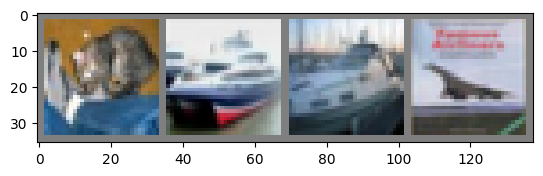

Labels: cat ship ship plane


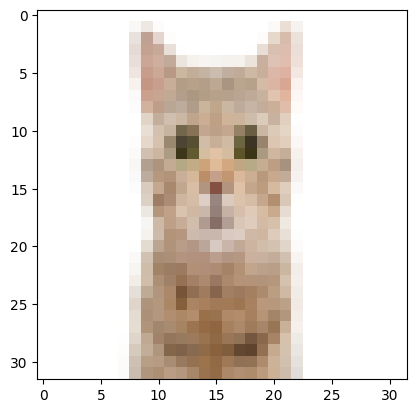

cat


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
images, labels = next(iter(testloader))

# show test images
imshow(torchvision.utils.make_grid(images))
print('Labels:', end = ' ')
print(' '.join(classes[label] for label in labels))
# show custom image
imshow(torchvision.utils.make_grid(input_tensor.to('cpu')))
print(prediction)
